In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import random
import torch
import torchaudio

from tqdm.notebook import tqdm

from model.binary import *

In [3]:
device = torch.device(f'cuda:0' if torch.cuda.is_available() else 'cpu')

audio_file = 'data/audio/20190819-Kutna Hora-L4-out-MVI_0040.wav'
labels_file = 'data/labels/20190819-Kutna Hora-L4-out-MVI_0040.txt'

signal, sr = torchaudio.load(audio_file)
signal = signal.mean(0)
# signal = signal.to(device)

events = np.loadtxt(labels_file)

In [4]:
model = ResNet18().to(device)

weights = torch.load(f'weights/binary/model_1627296035.pth', device)
model.load_state_dict(weights)

<All keys matched successfully>

In [5]:
dataset = VehicleDataset(audio_file, labels_file)

all: 384 | positive: 192


In [6]:
results = []

offset = 0.5
start_time = 25 * 60
T = 9 * 60

window_len = 1.0
n_samples_per_frame = int(sr * window_len)

X = np.linspace(0, T, int(T))

model.eval()
with torch.no_grad():
    for t in tqdm(X):
        
        t = int((t + start_time + offset) * sr)
    
        s = signal[t: t + n_samples_per_frame]
        s = dataset.transform(s)
        s = s.unsqueeze(0).to(device)
        y = model(s)
        y = torch.argmax(y).item()
        
        results.append(y)

  0%|          | 0/540 [00:00<?, ?it/s]

/home/yermaand/miniconda3/envs/dev/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


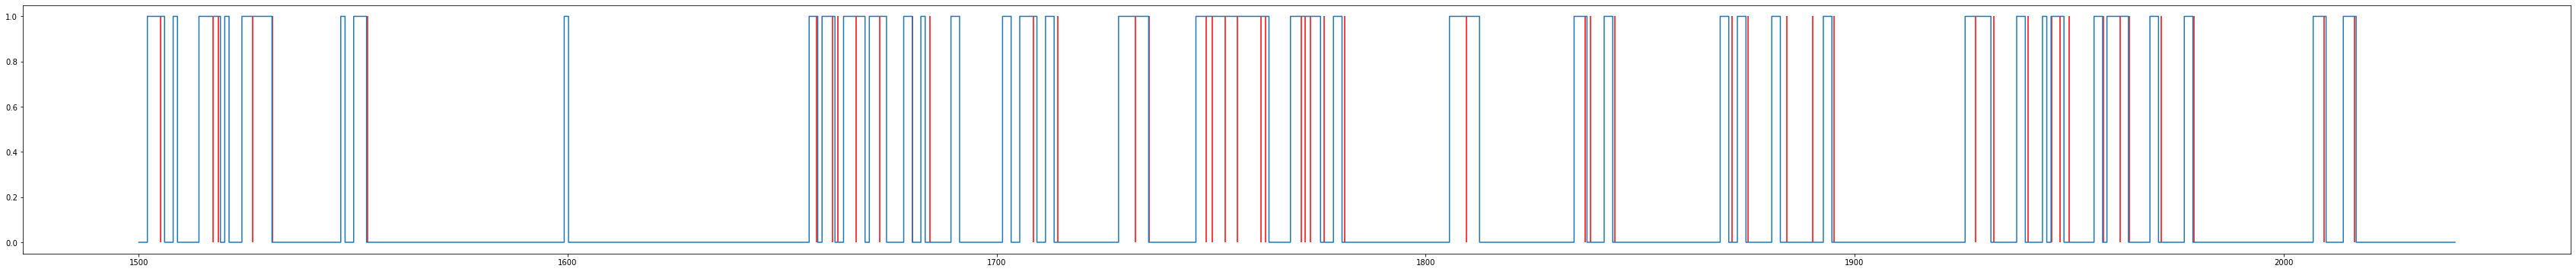

In [7]:
plt.figure(figsize=(60, 6))
plt.step(X + start_time, results);

for event in events[(events >= start_time) & (events < start_time + T)]:
    plt.vlines(event, 0, 1, color='r')

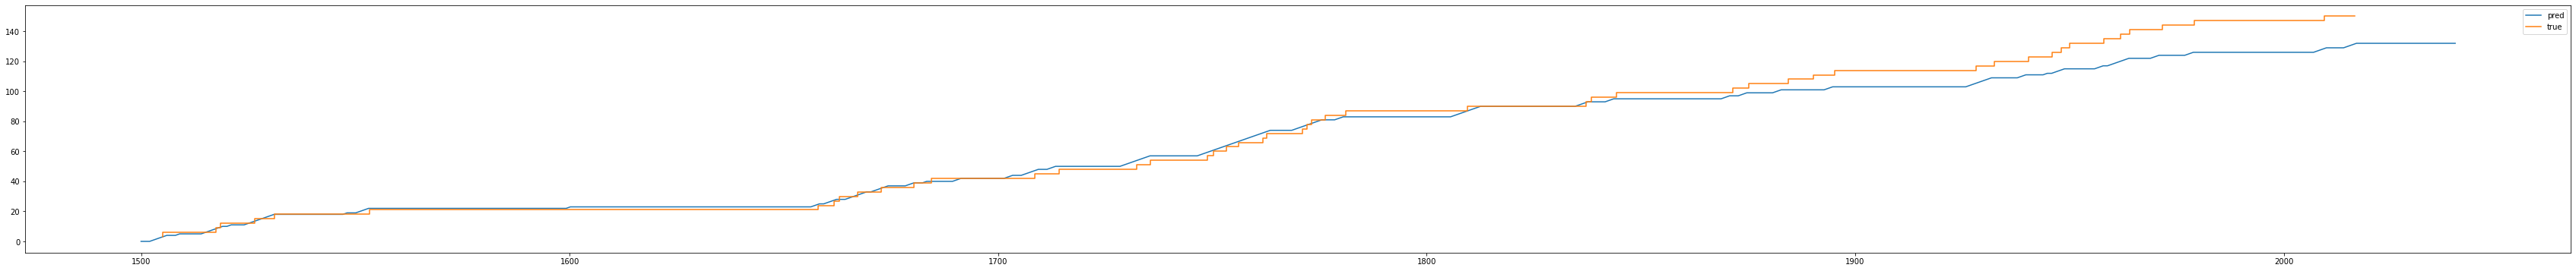

In [8]:
cumsum = np.cumsum(results)

fig, ax1 = plt.subplots(figsize=(60, 6))

ax1.plot(X + start_time, cumsum, label='pred')

E = events[(events >= start_time) & (events < start_time + T)]

ax1.step(E, (np.arange(len(E)) + 1) * 3, label='true')

plt.legend();